## Part 1: 
#### Convolutional network for image classification

#### Get data

In [21]:
!wget "http://chaladze.com/l5/img/Linnaeus%205%20128X128.rar"
!unrar x "/content/Linnaeus 5 128X128.rar"

Archive:  Linnaeus 5 128X128.zip
   creating: Linnaeus 5 128X128/Linnaeus 5 128X128/
   creating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/
   creating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/other/
  inflating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/other/33_128.jpg  
  inflating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/other/365_128.jpg  
  inflating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/other/293_128.jpg  
  inflating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/other/305_128.jpg  
  inflating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/other/298_128.jpg  
  inflating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/other/242_128.jpg  
  inflating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/other/89_128.jpg  
  inflating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/other/178_128.jpg  
  inflating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/other/166_128.jpg  
  inflating: Linnaeus 5 128X128/Linnaeus 5 128X128/test/other/181_128.jpg  
  inflating: Linnaeus 5 128X128/Linna

#### Import libraries

In [156]:
import os
import numpy as np
from matplotlib import image as img
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

current_path = ''

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#### Create dataloader

In [259]:
def get_img_path(main_path):
    data_path = {}
    for dir in os.listdir(main_path):
        data_path[dir] = []
        if not os.path.isfile(os.path.join(main_path, dir)):
            files_name = os.listdir(os.path.join(main_path, dir))
            np.random.shuffle(files_name)
            for img_name in files_name:
                data_path[dir].append(os.path.join(main_path, dir, img_name))
    return data_path

def dict2list(data):
    list_data = []
    for tag in data:
        list_data.extend(data[tag])
    np.random.shuffle(list_data)
    return list_data

def get_mean_std(train_data_path):
    all_data = []
    for path in train_data_path:
        image = img.imread(path)
        all_data.append(image.T)
    all_data = np.concatenate(all_data, axis=1)
    data_mean = (all_data / 255.0).mean(axis=(1,2))
    data_std = (all_data / 255.0).std(axis=(1,2))
    return data_mean, data_std
def get_data_path():
    train_and_val_img_path = get_img_path('Linnaeus 5 128X128/train')
    train_img_path = {tag:[] for tag in train_and_val_img_path.keys()}
    val_img_path = {tag:[] for tag in train_and_val_img_path.keys()}
    for tag in train_and_val_img_path.keys():
        split_index = int(0.1*len(train_and_val_img_path[tag]))
        train_img_path[tag] = train_and_val_img_path[tag][split_index:]
        val_img_path[tag] = train_and_val_img_path[tag][:split_index]
    test_img_path = get_img_path('Linnaeus 5 128X128/test')
    
    labels2id = {label:id for id, label in enumerate(list(train_img_path.keys()))}
    id2label = {id:label for label, id in labels2id.items()}
    train_img_path = dict2list(train_img_path)
    val_img_path = dict2list(val_img_path)
    test_img_path = dict2list(test_img_path)
    info = {'label2id': labels2id, 'id2label': id2label}
    return train_img_path, val_img_path, test_img_path, info

class ImageDataset(Dataset):
    def __init__(self, data_path, label2id, transform = None, device='cpu'):
        super().__init__()
        self.data_path = data_path
        self.transform = transform
        self.label2id = label2id
        self.device = device
        
    def __len__(self):
        return len(self.data_path)
    
    def __getitem__(self,index):
        img_path = self.data_path[index]
        image = img.imread(img_path)
        image = np.array(image)
        label = img_path.split('/')[-2]
        label = self.label2id[label]
        if self.transform is not None:
            image = self.transform(image)
        return image, label

train_img_path, val_img_path, test_img_path, info = get_data_path()
data_mean, data_std = get_mean_std(train_img_path)
print("images mean: ", data_std)
print("images std: ", data_std)

train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(data_mean, data_std)])
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(data_mean, data_std)])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(data_mean, data_std)])

train_dataset = ImageDataset(train_img_path, info['label2id'], train_transform, device)
val_dataset = ImageDataset(val_img_path, info['label2id'], val_transform, device)
test_dataset = ImageDataset(test_img_path, info['label2id'], test_transform, device)

batch_size = 64
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, num_workers=4)

images mean:  [0.26876741 0.25750381 0.27814098]
images std:  [0.26876741 0.25750381 0.27814098]


#### Create model

In [263]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.BN1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.BN2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 96, 5, padding=2)
        self.BN3 = nn.BatchNorm2d(96)

        self.conv4 = nn.Conv2d(96, 128, 3, padding=1)
        self.BN4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.BN5 = nn.BatchNorm2d(128)

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.relu(self.BN1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.BN2(self.conv2(x)))
        x = self.pool1(x)

        x = F.relu(self.BN3(self.conv3(x)))
        x = self.pool2(x)
   
        x = F.relu(self.BN4(self.conv4(x)))
        x = self.pool2(x)
        
        x = F.relu(self.BN5(self.conv5(x)))
        x = self.pool2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def get_feature_map(self, x):
        x = self.conv1(x)
        return x

#### Train model

In [264]:
import torch.optim as optim

model = Model()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [265]:
from tqdm import tqdm 

def train_model(model, train_loader, val_loader, epoch, model_path):
    train_loss_per_epoch, val_loss_per_epoch = [], []
    for epoch in range(epoch):  # loop over the dataset multiple times
        train_epoch_loss = []
        train_loop = tqdm(train_loader, leave=True)
        for step, data in enumerate(train_loop):
            model.train()
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            train_epoch_loss.append(loss.item())
            # print(len(train_loader))
            if step % (len(train_loader)//10) == (len(train_loader)//10)-1:
                train_loss = sum(train_epoch_loss)/len(train_epoch_loss)
                train_loop.set_description(f'epoch {epoch}')
                train_loop.set_postfix({'train loss': train_loss})

            if step == len(train_loader)-1:
                model.eval()
                val_epoch_loss = []
                for val_step, val_data in enumerate(val_loader):
                    # get the inputs; data is a list of [inputs, labels]
                    inputs, labels = val_data
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_epoch_loss.append(loss.item())
                train_loop.set_description(f'epoch {epoch}')
                val_loss = sum(val_epoch_loss)/len(val_epoch_loss)
                train_loss = sum(train_epoch_loss)/len(train_epoch_loss)
                train_loop.set_postfix({'train loss': train_loss, 'val loss': val_loss})
        train_loss = sum(train_epoch_loss)/len(train_epoch_loss)
        val_loss = sum(val_epoch_loss)/len(val_epoch_loss)
        train_loss_per_epoch.append(train_loss)
        val_loss_per_epoch.append(val_loss)
        ## save model
        torch.save(model.state_dict(), model_path)
    return model, train_loss_per_epoch, val_loss_per_epoch

In [266]:
model, train_loss_per_epoch, val_loss_per_epoch = train_model(model, val_loader, val_loader, 70, os.path.join(current_path, 'model.pth'))

epoch 69: 100%|██████████| 10/10 [00:01<00:00,  5.56it/s, train loss=0.0044, val loss=0.0084]


#### Plot train and validation loss

In [267]:
def plot_losses(losses, path, title):
    plt.plot(losses['train_loss'], label='train')
    plt.plot(losses['val_loss'], label='val')
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig(path)
    print(f"The loss change diagram was saved in {path}")

The loss change diagram was saved in loss_q1.jpg


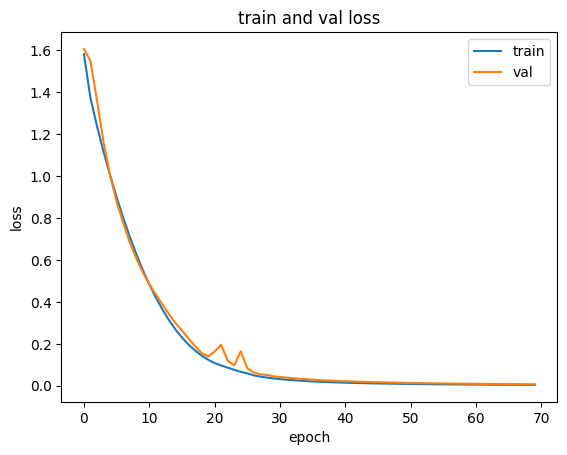

In [171]:
plot_losses({'train_loss': train_loss_per_epoch, 'val_loss': val_loss_per_epoch}, 'loss_q1.jpg', 'train and val loss')

#### Evaluate model

In [174]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(test_loader, model):
    model.eval()
    test_loop = tqdm(test_loader, leave=True)
    test_loss_per_step = []
    true_labels, predicted_labels = [], []
    for step, data in enumerate(test_loop):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

        test_loss_per_step.append(loss.item())
        test_loss = sum(test_loss_per_step)/len(test_loss_per_step)
        if step%10:
            test_loop.set_description('evaluate model')
            test_loop.set_postfix({'test loss': test_loss})
    print()
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    print(f" precision: {precision}\n recall: {recall}\n F1:{f1}")

In [175]:
evaluate_model(test_loader, model)

evaluate model: 100%|██████████| 32/32 [00:01<00:00, 28.87it/s, test loss=1.13]



 precision: 0.6223845215880898
 recall: 0.616
 F1:0.6145218169340915


#### Plot feature map 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


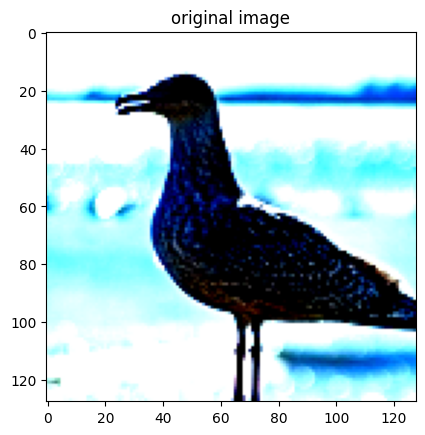

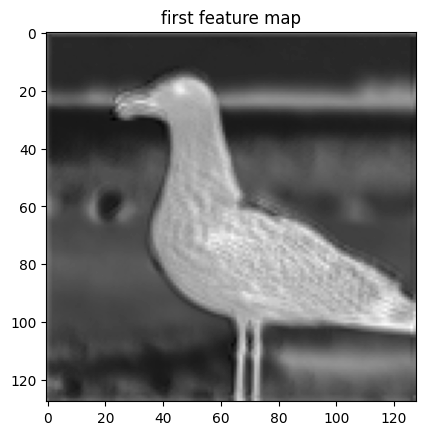

In [117]:
def plot_image(image, title, gray=False):
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.title(title)
    plt.show()
 
def plot_feature_map(data):
    image = np.transpose(data.numpy(), (1, 2, 0))
    plot_image(image, 'original image')
    feature_map = model.get_feature_map(data.to(device)).cpu()
    plot_image(feature_map[0].detach().numpy(), 'first feature map', True)

model.eval()
data, label = next(iter(train_loader))
plot_feature_map(data[0])

## Part2: 
#### Use residual connection in previouse connection

In [253]:
import torch.nn as nn
import torch.nn.functional as F

class ResModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.BN1 = nn.BatchNorm2d(32)

        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.BN2 = nn.BatchNorm2d(64)

        self.res_conv1 = nn.Conv2d(64, 128, 5, stride=2, padding=2)
        self.res_BN1 = nn.BatchNorm2d(128)
        self.res_pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv3 = nn.Conv2d(64, 96, 5, padding=2)
        self.BN3 = nn.BatchNorm2d(96)

        self.conv4 = nn.Conv2d(96, 128, 3, padding=1)
        self.BN4 = nn.BatchNorm2d(128)
        
        self.conv5 = nn.Conv2d(128, 128, 3, padding=1)
        self.BN5 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 5)

    def forward(self, x):
        x = F.relu(self.BN1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.BN2(self.conv2(x)))
        x = self.pool1(x)

        res_x1 = F.relu(self.res_conv1(x)) ## residual 
        res_x1 = self.res_pool1(res_x1)

        x = F.relu(self.BN3(self.conv3(x)))
        x = self.pool2(x)

        x = F.relu(self.BN4(self.conv4(x)))
        x = self.pool2(x)
        
        x = F.relu(self.BN5(self.conv5(x+res_x1)))
        x = self.pool2(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


#### Train model

In [260]:
import torch.optim as optim

res_model = ResModel()
res_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_model.parameters(), lr=5e-5)

res_model, train_loss_per_epoch, val_loss_per_epoch = train_model(res_model, train_loader, val_loader, 15, os.path.join(current_path, 'res_model.pth'))

epoch 14: 100%|██████████| 85/85 [00:03<00:00, 21.56it/s, train loss=0.119, val loss=0.687]


#### Plot train and validation loss

The loss change diagram was saved in loss_q1.jpg


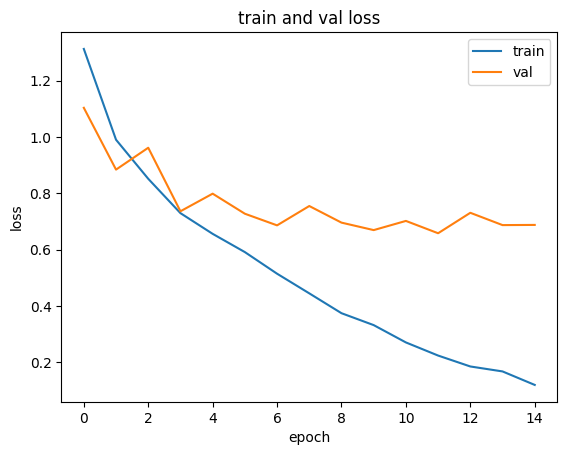

In [261]:
plot_losses({'train_loss': train_loss_per_epoch, 'val_loss': val_loss_per_epoch}, 'loss_q1.jpg', 'train and val loss')

#### Evaluate

In [262]:
evaluate_model(test_loader, res_model)

evaluate model: 100%|██████████| 32/32 [00:01<00:00, 25.40it/s, test loss=0.73] 



 precision: 0.7620305639231469
 recall: 0.7474999999999999
 F1:0.7497942257861391


## Part3: 
#### Add Inseption block

#### Create Model

In [222]:
import torch.nn as nn
import torch.nn.functional as F

class InseptionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.inception1 = self.get_inception_block(channels={'input':3, 'out_1*1_left':16, 'in_3*3':8, 'out_3*3':16, 'in_5*5':8, 'out_5*5':16, 'out_1*1_right':16})
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.inception2 = self.get_inception_block(channels={'input':64, 'out_1*1_left':24, 'in_3*3':32, 'out_3*3':48, 'in_5*5':16, 'out_5*5':12, 'out_1*1_right':12})
        self.inception3 = self.get_inception_block(channels={'input':96, 'out_1*1_left':16, 'in_3*3':32, 'out_3*3':48, 'in_5*5':32, 'out_5*5':16, 'out_1*1_right':16})
        self.inception4 = self.get_inception_block(channels={'input':96, 'out_1*1_left':32, 'in_3*3':32, 'out_3*3':48, 'in_5*5':16, 'out_5*5':24, 'out_1*1_right':24})
        self.inception5 = self.get_inception_block(channels={'input':128, 'out_1*1_left':32, 'in_3*3':48, 'out_3*3':64, 'in_5*5':16, 'out_5*5':16, 'out_1*1_right':16})
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 5)

    def get_inception_block(self, channels):
        cov_1_by_1_left = nn.Sequential(
            nn.Conv2d(channels['input'], channels['out_1*1_left'], 1),
            nn.BatchNorm2d(channels['out_1*1_left']),
            nn.ReLU()
        )
        cov_3_by_3 = nn.Sequential(
            nn.Conv2d(channels['input'], channels['in_3*3'], 1),
            nn.BatchNorm2d(channels['in_3*3']),
            nn.ReLU(),
            nn.Conv2d(channels['in_3*3'], channels['out_3*3'], 3, padding=1),
            nn.ReLU()
        )
        cov_5_by_5 = nn.Sequential(
            nn.Conv2d(channels['input'], channels['in_5*5'], 1),
            nn.BatchNorm2d(channels['in_5*5']),
            nn.ReLU(),
            nn.Conv2d(channels['in_5*5'], channels['out_5*5'], 5, padding=2),
            nn.ReLU()
        )
        cov_1_by_1_right = nn.Sequential(
            nn.MaxPool2d(3, padding=1, stride=1),
            nn.Conv2d(channels['input'], channels['out_1*1_right'], 1),
            nn.BatchNorm2d(channels['out_1*1_right']),
            nn.ReLU()
        )
        return nn.ModuleList([cov_1_by_1_left, cov_3_by_3, cov_5_by_5, cov_1_by_1_right])

    def inception_forward(self, inception_block, x):
        out1 = inception_block[0](x)
        out2 = inception_block[1](x)
        out3 = inception_block[2](x)
        out4 = inception_block[3](x)
        out = torch.cat((out1, out2, out3, out4), dim=1)
        return out

    def forward(self, x):
        x = self.inception_forward(self.inception1, x)
        x = self.pool1(x)
        x = self.inception_forward(self.inception2, x)
        x = self.pool1(x)
        x = self.inception_forward(self.inception3, x)
        x = self.pool2(x)
        x = self.inception_forward(self.inception4, x)
        x = self.pool2(x)
        x = self.inception_forward(self.inception5, x)
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#### Train model

In [225]:
model = InseptionModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

model, train_loss_per_epoch, val_loss_per_epoch = train_model(model, train_loader, val_loader, 15, os.path.join(current_path, 'model_inception.pth'))

epoch 14: 100%|██████████| 85/85 [00:06<00:00, 12.46it/s, train loss=0.489, val loss=0.71]


#### plot train and validation loss

The loss change diagram was saved in loss_q2.jpg


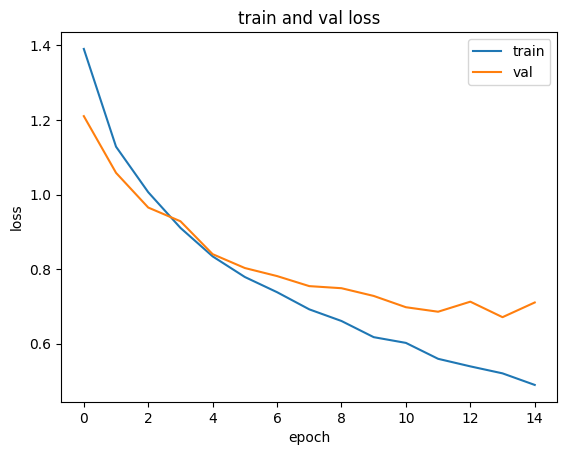

In [226]:
plot_losses({'train_loss': train_loss_per_epoch, 'val_loss': val_loss_per_epoch}, 'loss_q2.jpg', 'train and val loss')

#### Evaluate model

In [227]:
evaluate_model(test_loader, model)

evaluate model: 100%|██████████| 32/32 [00:01<00:00, 23.52it/s, test loss=0.692]



 precision: 0.7381568542635009
 recall: 0.7315
 F1:0.7309577666958893


## Part4:
#### Transfer learning

#### Get data

In [176]:
!wget "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
!tar -zxvf flower_photos.tgz

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

#### Resize images to 128*128

In [177]:
from PIL import Image
def resize_images():
    all_img_path = get_img_path('flower_photos')
    for class_name in all_img_path:
        for path in all_img_path[class_name]:
            im = Image.open(path)
            im = im.resize((128, 128))
            im.save(path)

resize_images()

#### Create dataloader

In [229]:
def get_new_data_path():
    img_path = get_img_path('flower_photos')
    train_img_path = {tag:[] for tag in img_path.keys()}
    val_img_path = {tag:[] for tag in img_path.keys()}
    test_img_path = {tag:[] for tag in img_path.keys()}
    for tag in img_path.keys():
        split_index1 = int(0.1*len(img_path[tag]))
        split_index2 = int(0.3*len(img_path[tag]))
        test_img_path[tag] = img_path[tag][:split_index1]
        val_img_path[tag] = img_path[tag][split_index1:split_index2]
        train_img_path[tag] = img_path[tag][split_index2:]
    
    labels2id = {label:id for id, label in enumerate(list(train_img_path.keys()))}
    id2label = {id:label for label, id in labels2id.items()}
    train_img_path = dict2list(train_img_path)
    val_img_path = dict2list(val_img_path)
    test_img_path = dict2list(test_img_path)
    info = {'label2id': labels2id, 'id2label': id2label}
    return train_img_path, val_img_path, test_img_path, info

train_img_path, val_img_path, test_img_path, info = get_new_data_path()
data_mean, data_std = get_mean_std(train_img_path)
print("images mean: ", data_std)
print("images std: ", data_std)
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(data_mean, data_std)])
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(data_mean, data_std)])
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(data_mean, data_std)])

train_dataset = ImageDataset(train_img_path, info['label2id'], train_transform)
val_dataset = ImageDataset(val_img_path, info['label2id'], val_transform)
test_dataset = ImageDataset(test_img_path, info['label2id'], test_transform)

batch_size = 64
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=False, num_workers=4)

images mean:  [0.29144324 0.26347981 0.28348392]
images std:  [0.29144324 0.26347981 0.28348392]


#### Create Model

In [233]:
import torch.nn as nn
import torch.nn.functional as F

class Model2(nn.Module):
    def __init__(self, base_model, n_classes):
        super().__init__()
        self.base_model = base_model
        self.fc1 = nn.Linear(5, 128)
        self.fc2 = nn.Linear(128, n_classes)

    def get_model_layers(self):
        layers = {'inception1': self.base_model.inception1, 'inception2': self.base_model.inception2, 'inception3': self.base_model.inception3, 
                  'inception4': self.base_model.inception4, 'inception5': self.base_model.inception5, 'fc': [self.base_model.fc1, self.base_model.fc2], 
                  'classifier': [self.fc1, self.fc2]}
        return layers

    def set_trainable_layers(self, trainable):
        layers = self.get_model_layers()
        for layer_name in layers.keys():
            if layer_name in trainable:
                for sub_layer in layers[layer_name]:
                    for p in sub_layer.parameters():
                        p.requires_grad = True
            else:
                for sub_layer in layers[layer_name]:
                    for p in sub_layer.parameters():
                        p.requires_grad = False

    def forward(self, x):
        x = self.base_model(x)
        x = F.relu(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [246]:
pretrained_model = InseptionModel()
path = os.path.join(current_path, 'model_inception.pth')
pretrained_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [247]:
model2 = Model2(pretrained_model, len(info['label2id']))
model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=5e-5)

#### Train model in some epochs: first train classifier and then finetune pretrained model step-by-step

In [248]:
from tqdm import tqdm 

train_loss_per_epoch, val_loss_per_epoch = [], []
for epoch in range(25):  # loop over the dataset multiple times
    if epoch == 0:
        trainable_layers = {'inception1': False, 'inception2': False, 'inception3': False, 'inception4': False, 'inception5': False, 'fc': False, 'classifier': True}
    elif epoch == 1:
        trainable_layers = {'inception1': False, 'inception2': False, 'inception3': False, 'inception4': False, 'inception5': False, 'fc': True, 'classifier': True}
    elif epoch == 2:
        trainable_layers = {'inception1': False, 'inception2': False, 'inception3': False, 'inception4': False, 'inception5': True, 'fc': True, 'classifier': True}
    elif epoch == 3:
        trainable_layers = {'inception1': False, 'inception2': False, 'inception3': False, 'inception4': True, 'inception5': True, 'fc': True, 'classifier': True}
    elif epoch == 4:
        trainable_layers = {'inception1': False, 'inception2': False, 'inception3': True, 'inception4': True, 'inception5': True, 'fc': True, 'classifier': True}
    elif epoch == 5:
        trainable_layers = {'inception1': False, 'inception2': True, 'inception3': True, 'inception4': True, 'inception5': True, 'fc': True, 'classifier': True}
    else:
        trainable_layers = {'inception1': True, 'inception2': True, 'inception3': True, 'inception4': True, 'inception5': True, 'fc': True, 'classifier': True}

    model2.set_trainable_layers(trainable_layers)
    train_epoch_loss = []
    train_loop = tqdm(train_loader, leave=True)
    for step, data in enumerate(train_loop):
        model2.train()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_epoch_loss.append(loss.item())
        if step%(len(train_loader)//3) == 0:    # print every 10 mini-batches
            model2.eval()
            val_epoch_loss = []
            for val_step, val_data in enumerate(val_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = val_data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model2(inputs)
                loss = criterion(outputs, labels)
                val_epoch_loss.append(loss.item())

            train_loop.set_description(f'epoch {epoch}')
            train_loss = sum(train_epoch_loss)/len(train_epoch_loss)
            val_loss = sum(val_epoch_loss)/len(val_epoch_loss)
            train_loop.set_postfix({'train loss': train_loss, 'val loss': val_loss})
    train_loss = sum(train_epoch_loss)/len(train_epoch_loss)
    val_loss = sum(val_epoch_loss)/len(val_epoch_loss)
    train_loss_per_epoch.append(train_loss)
    val_loss_per_epoch.append(val_loss)
    ## save model
    torch.save(model2.state_dict(), os.path.join(current_path, 'model_transfered.pth'))


epoch 24: 100%|██████████| 41/41 [00:06<00:00,  6.01it/s, train loss=0.358, val loss=0.824]


#### Plot loss

The loss change diagram was saved in loss_transfer_learning.jpg


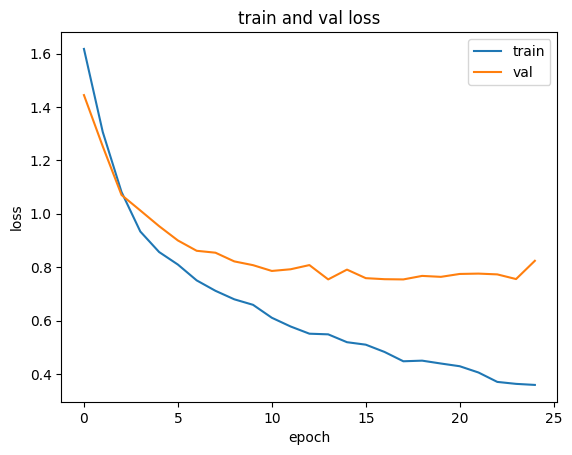

In [249]:
plot_losses({'train_loss': train_loss_per_epoch, 'val_loss': val_loss_per_epoch}, 'loss_transfer_learning.jpg', 'train and val loss')

#### Evaluate model

In [250]:
evaluate_model(test_loader, model2)

evaluate model: 100%|██████████| 6/6 [00:00<00:00,  7.90it/s, test loss=0.805]



 precision: 0.7251865501865502
 recall: 0.7035599983666929
 F1:0.7045274677311031
